In [1]:
import torch
from ogb.utils import smiles2graph
from torch_geometric.data import Data
from model_nn import MPNN, MCULE_DATA
import pytorch_lightning as pl
import numpy as np
import random
from deepchem.splits import RandomSplitter
import pandas as pd
from tqdm import tqdm

torch.manual_seed(0)
torch.cuda.manual_seed(0)
np.random.seed(0)
random.seed(0)


dataset = MCULE_DATA('./datasets/').shuffle()

splitter = RandomSplitter()
train_idx, valid_idx, test_idx = splitter.split(dataset,frac_train=0.7, frac_valid=0.1, frac_test=0.2)
train_dataset = dataset[list(train_idx)]
valid_dataset = dataset[list(valid_idx)]
test_dataset = dataset[list(test_idx)]

mean = dataset.data.y.mean()
std = dataset.data.y.std()
print(std)


wandb: WARNING W&B installed but not logged in.  Run `wandb login` or set the WANDB_API_KEY env variable.
wandb: WARNING W&B installed but not logged in.  Run `wandb login` or set the WANDB_API_KEY env variable.
Skipped loading some Jax models, missing a dependency. jax requires jaxlib to be installed. See https://github.com/google/jax#installation for installation instructions.


tensor(47.2647)


c:\Users\loicb\miniconda3\lib\site-packages\torch_geometric\data\in_memory_dataset.py:157: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. The given 'InMemoryDataset' only references a subset of examples of the full dataset, but 'data' will contain information of the full dataset. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)


In [2]:
model = MPNN(
    hidden_dim=80,
    out_dim=1,
    std=std,
    train_data=train_dataset,
    valid_data=valid_dataset,
    test_data=test_dataset,
    lr=0.001,
    batch_size=64
)

model.load_state_dict(torch.load('gnn_model.pth'))
model.eval()



MPNN(
  (atom_emb): AtomEncoder(
    (atom_embedding_list): ModuleList(
      (0): Embedding(119, 80)
      (1): Embedding(5, 80)
      (2-3): 2 x Embedding(12, 80)
      (4): Embedding(10, 80)
      (5-6): 2 x Embedding(6, 80)
      (7-8): 2 x Embedding(2, 80)
    )
  )
  (bond_emb): BondEncoder(
    (bond_embedding_list): ModuleList(
      (0): Embedding(5, 80)
      (1): Embedding(6, 80)
      (2): Embedding(2, 80)
    )
  )
  (conv): NNConv(80, 80, aggr=mean, nn=MLP(80, 160, 6400))
  (gru): GRU(80, 80)
  (mlp): MLP(80, 40, 1)
)

In [3]:
df=pd.read_csv('mcule_purchasable_in_stock_prices_valid_smiles.csv')
smiles = df['SMILES'][100000:101000]
target = df['price 1 (USD)'][100000:101000].values.tolist()

df2=pd.DataFrame({'SMILES':smiles, 'target':target})
df2['graph']=df2['SMILES'].apply(smiles2graph)

print(df2)

C:\Users\loicb\AppData\Local\Temp\ipykernel_1256\3878595.py:1: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df=pd.read_csv('mcule_purchasable_in_stock_prices_valid_smiles.csv')


                                                   SMILES  target  \
100000       C1(=NN=CS1)NC(=O)C1=CC=C2C(C(O)=CC(C)=N2)=C1    88.9   
100001  C1(C(=O)NCC2=CC=CN=C2)=CN(CC)C2C(=CC(=CC=2)OC)...    88.9   
100002  C1(=CN=C2C=CC(=CC2=C1N)NC(=O)C1C=CC=C(OC)C=1)C...    88.9   
100003  C1(C=NC2=CC(F)=CC(F)=C2C=1O)C(=O)NC1C=CC=C(Br)C=1    88.9   
100004  C1(C(=O)NC2C=CC=C(Br)C=2)=CN(CC)C2C(=CC(=CC=2)...    88.9   
...                                                   ...     ...   
100995  C12NC(C(O)=O)=CC(C3C=C(OC)C(=C(OC)C=3)OC)N1N=C...    88.9   
100996  C12C=NC3=NC(C)=NN3C=1C=CN(C1=CC=C(C(C)=O)C=C1)...    88.9   
100997  C12C=NC3=NC(C)=NN3C=1C=CN(C1C=CC(=CC=1)OC(F)(F...    88.9   
100998  C1(C(F)(F)F)=NN2C(N=CC3C(N(C4=CC=C(Cl)C=C4)C=C...    88.9   
100999  C1(C(F)(F)F)=NN2C(N=CC3C(N(C4=CC=C(OC)C=C4)C=C...    88.9   

                                                    graph  
100000  {'edge_index': [[0, 1, 1, 2, 2, 3, 3, 4, 0, 5,...  
100001  {'edge_index': [[0, 1, 1, 2, 1, 3, 3, 4, 4,

In [15]:
print(df2['SMILES'][100000])

C1(=NN=CS1)NC(=O)C1=CC=C2C(C(O)=CC(C)=N2)=C1


In [4]:
data_list=[]
for i, smi in enumerate(tqdm(smiles)):
    # convert to tensor and pyg data
    x = torch.tensor(df2['graph'][100000+i]['node_feat'], dtype=torch.long)
    edge_index = torch.tensor(df2['graph'][100000+i]['edge_index'], dtype=torch.long)
    edge_attr = torch.tensor(df2['graph'][100000+i]['edge_feat'], dtype=torch.long)
    y = torch.tensor([target[i]], dtype=torch.float)
    data = Data(x=x, edge_index=edge_index, edge_attr=edge_attr, y=y)
    data_list.append(data)

100%|██████████| 1000/1000 [00:00<00:00, 13822.06it/s]


In [5]:
predict= []
for i in range(1000):
    dat=data_list[i]
    with torch.no_grad():
        predict.append(float(model(dat)))

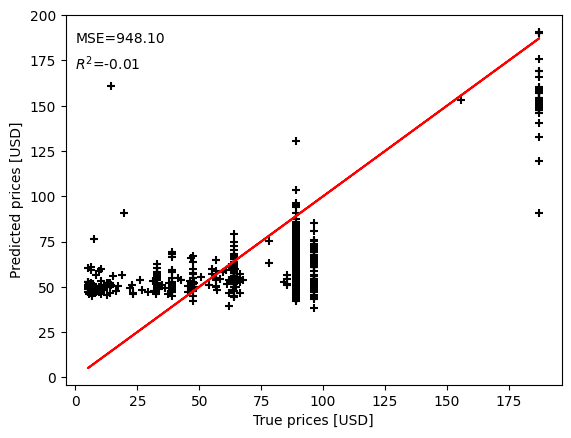

In [12]:
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
# Plot
plt.scatter(target, predict, marker='+', color='black')
plt.plot(target, target, color='red')

plt.xlabel('True prices [USD]')
plt.ylabel('Predicted prices [USD]')
plt.text(0, 170, f'$R^2$={r2_score(target, predict):.2f}')
plt.text(0, 185, f'MSE={mean_squared_error(target, predict):.2f}')
plt.savefig("test_nn.png", dpi=800)
plt.show()